# Introduction

During their lifetime, aircraft components are susceptible to degradation, which affects directly their reliability and performance. This machine learning project will be directed to provide a framework for predict- ing the aircraft’s remaining useful life (RUL) based on the entire life cycle data in order to provide the necessary maintenance behavior. Diverse regression, classification models (KNN, Naïve Bayes, Random Forest, SVM, etc..) are deployed and tested on the NASA’s C-MAPSS data-set to assess the engine’s lifetime. Please check the report for more theoretical details

 <figure>
  <div align='center'>
    <img src='https://i.postimg.cc/gcvWCNHf/Turbofan-operation-lbp.png' alt='Your Image Description'>
  </div>
  <div align='center'>
    <figcaption>Figure 1: A Turbofan Jet Engine Schematics.
</figcaption>
  </div>
</figure>

In [61]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

# Main Libraries

In [44]:
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import warnings
import pandas as pd
import numpy as np
import random
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

## Loading data

In [16]:
# define filepath to read data
dir_path = './data/CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr','time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Before we start plotting our data to continue our EDA, we’ll compute a target variable for Remaining Useful Life (RUL). The target variable will serve two purposes:

1. It will serve as our X-axis while plotting sensor signals, allowing us to easily interpret changes in the sensor signals as the engines near breakdown.
2. It will serve as target variable for our supervised machine learning models.

Without further information about the RUL of engines in the training set, we’ll have to come up with estimates of our own. We’ll assume the RUL decreases linearly over time and have a value of 0 at the last time cycle of the engine. This assumption implies RUL would be 10 at 10 cycles before breakdown, 50 at 50 cycles before breakdown, etc.

Mathematically we can use ```max_time_cycle — time_cycle``` to compute our desired RUL. Since we want to take the ```max_time_cycle``` of each engine into account, we’ll group the dataframe by unit_nr before computing max_time_cycle. ```The max_time_cycle``` is then merged back into the dataframe to allow easy calculation of RUL by subtracting the columns ```max_time_cycle — time_cycle```. Afterwards we drop ```max_time_cycle``` as it’s no longer needed and inspect the first few rows to verify our RUL calculation.

In [17]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Baseline Model

For the baseline model we’ll train a linear regression on the available sensors and engine settings. We’ll set the upper limit of the computed RUL to 125, as it better reflects what we know about the engines RUL [1].

In [18]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() 

In [19]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [20]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.660359801722635, R2:0.5795961126406308
test set RMSE:32.041094781744256, R2:0.4054954961204257


Our baseline model has a low training RMSE and a low test RMSE, which will be the score to beat. Let’s move on to plotting to select our features.

## Plotting

To make sense of the sensor values, we’ll apply the same operating condition-based standardization as last time. This form of standardization essentially applies a standard scaler to each group of datapoints which are running on the same operating condition, centralizing their means and ‘stitching’ the signal together. This form of standardization works for this dataset because the different operating conditions shift the mean of the signal (but doesn’t seem to affect the signal or breakdown in any other way).

In [21]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test
  
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

We’ll first concatenate the values of the settings to get a single variable which indicates the operating condition. Then, we’ll iterate over the groups of operating conditions to fit the standard scaler on the train set and transform both the train and test set. We can now look at some plots.

In [23]:
data=train.copy()
test_data=test.copy()

test_data['increasing']=test_data['s_2']+ test_data['s_3']+ test_data['s_4']+test_data['s_8']+test_data['s_13']+ test_data['s_15']+test_data['s_17']
data['increasing']=data['s_2']+ data['s_3']+ data['s_4']+data['s_8']+data['s_13']+ data['s_15']+data['s_17']
data['decreasing']=data['s_7']+data['s_12'] + data['s_20'] + data['s_21']
test_data['decreasing']=test_data['s_7']+test_data['s_12'] + test_data['s_20'] + test_data['s_21']

data.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,increasing,decreasing
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,8808.6195,1138.4990
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,8813.6518,1138.4536
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,8809.0678,1138.9742
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,8803.5682,1139.5639
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,8808.9694,1138.4944


In [27]:
def plot_sensor(sensor_name, X):
    plt.figure(figsize=(10,3))
    for i in X['unit_nr'].unique():
        if (i % 10 == 0):
            data_subset = X[X['unit_nr'] == i]
            plt.plot(data_subset['RUL'].to_numpy(), data_subset[sensor_name].to_numpy())
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

Sensor 1 - (Fan inlet temperature) (◦R)


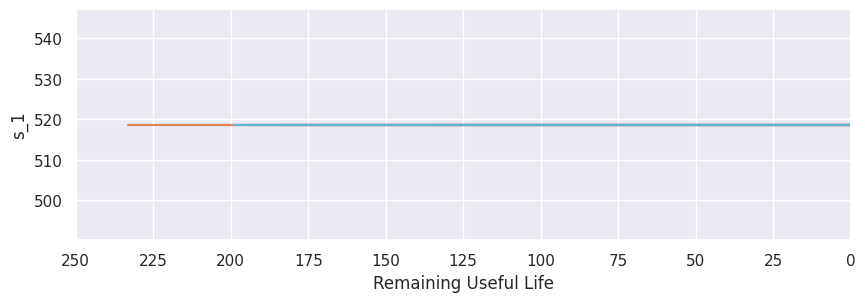




Sensor 2 - (LPC outlet temperature) (◦R)


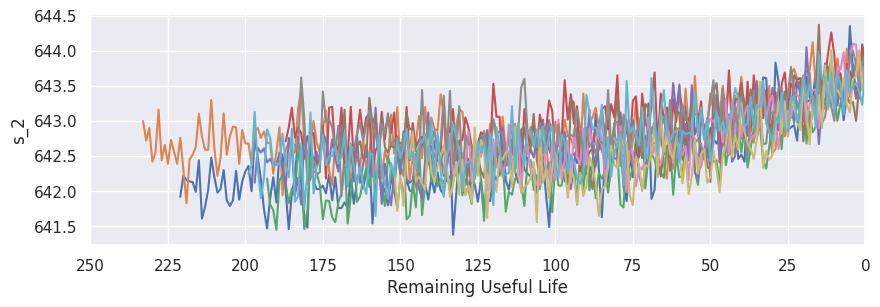




Sensor 3 - (HPC outlet temperature) (◦R)


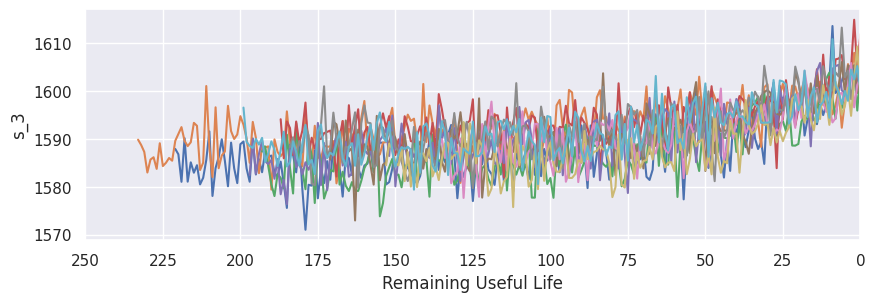




Sensor 4 - (LPT outlet temperature) (◦R)


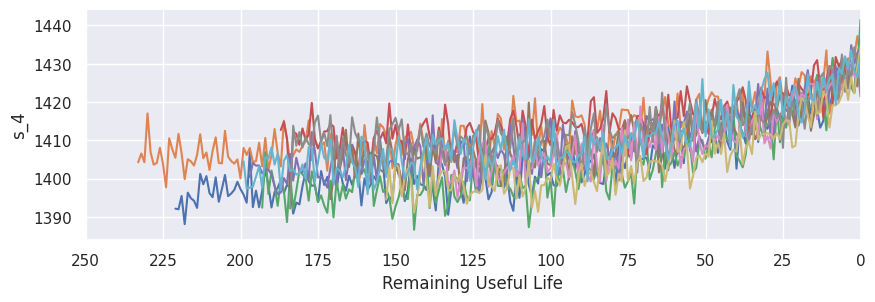




Sensor 5 - (Fan inlet Pressure) (psia)


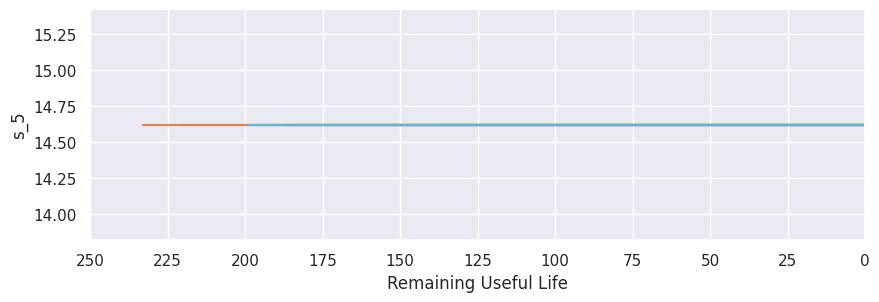




Sensor 6 - (bypass-duct pressure) (psia)


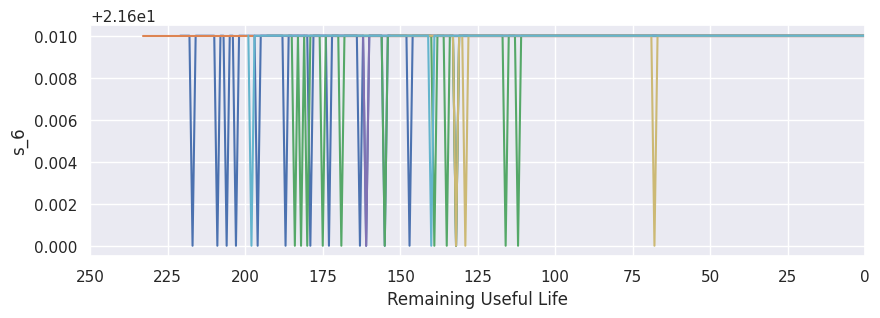




Sensor 7 - (HPC outlet pressure) (psia)


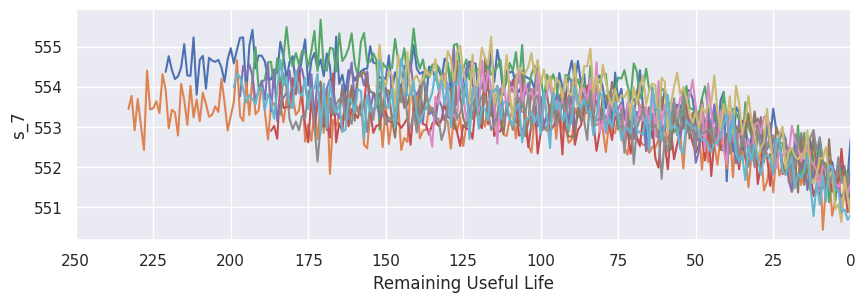




Sensor 8 - (Physical fan speed) (rpm)


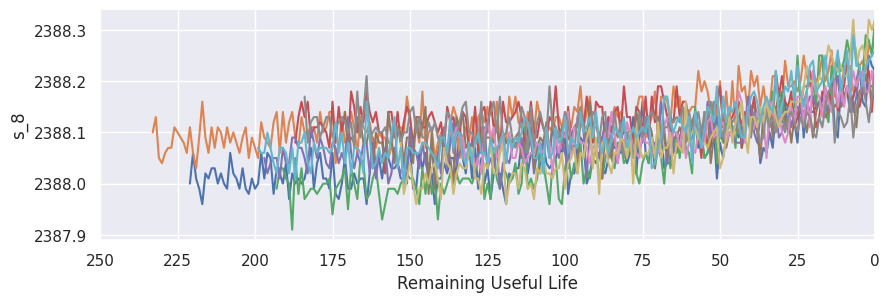




Sensor 9 - (Physical core speed) (rpm)


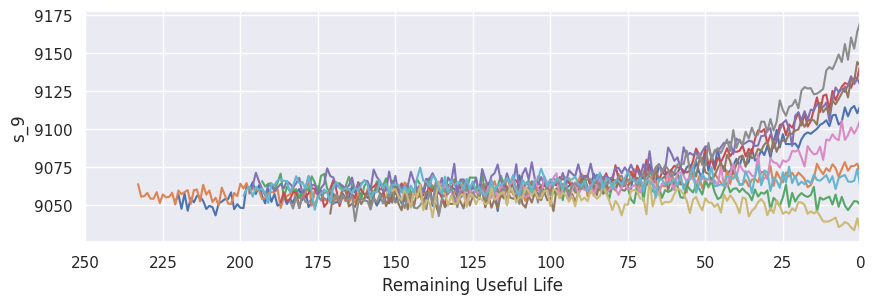




Sensor 10 - (Engine pressure ratio(P50/P2)


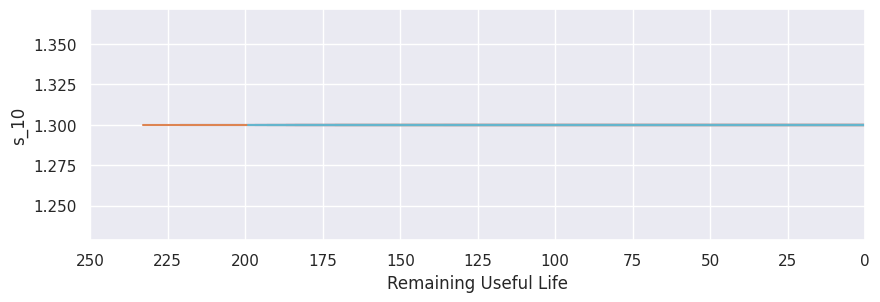




Sensor 11 - (HPC outlet Static pressure) (psia)


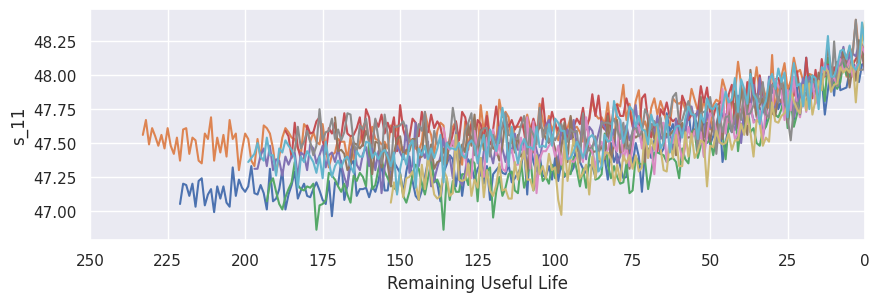




Sensor 12 - (Ratio of fuel flow to Ps30) (pps/psia)


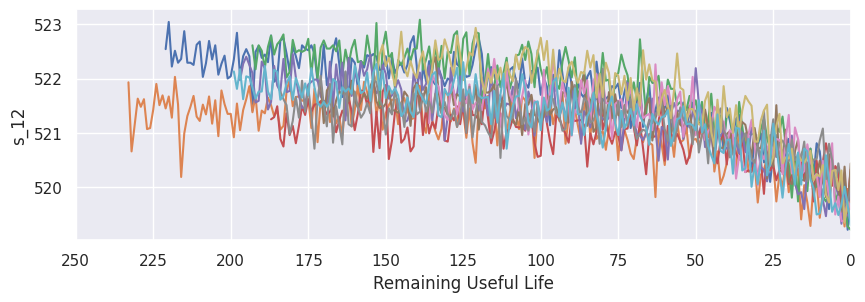




Sensor 13 - (Corrected fan speed) (rpm)


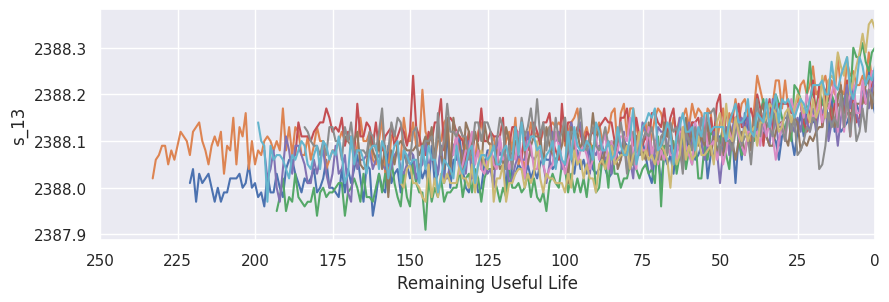




Sensor 14 - (Corrected core speed) (rpm)


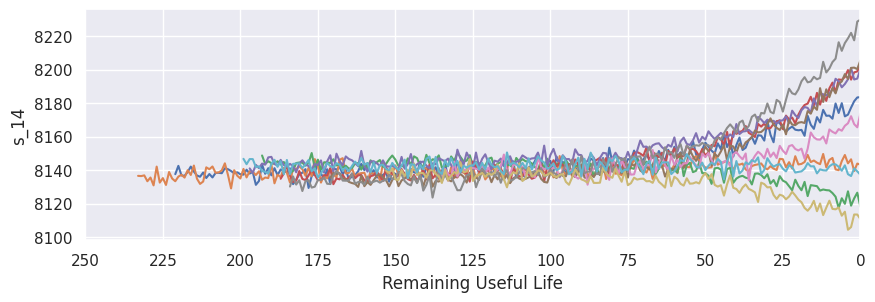




Sensor 15 - (Bypass Ratio) 


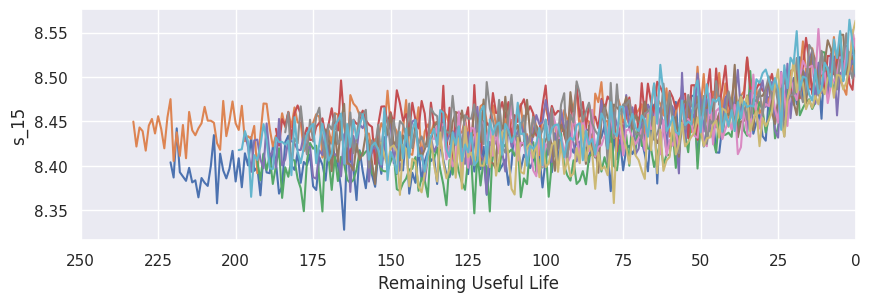




Sensor 16 - (Burner fuel-air ratio)


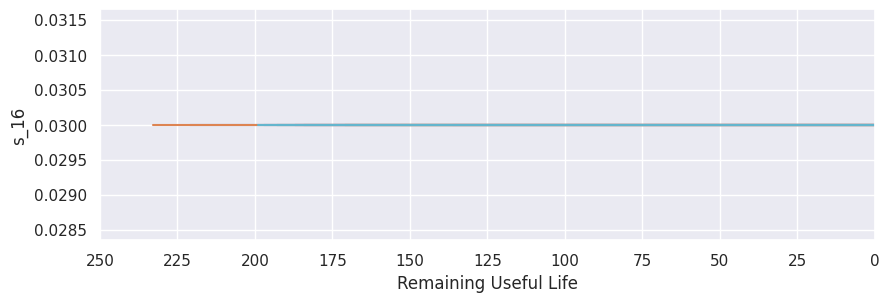




Sensor 17 - (Bleed Enthalpy)


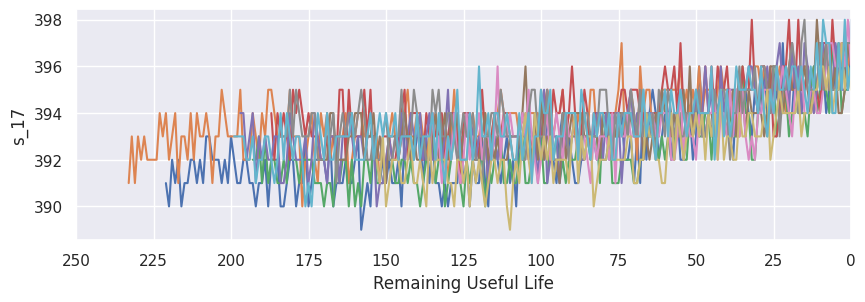




Sensor 18 - (Required fan speed)


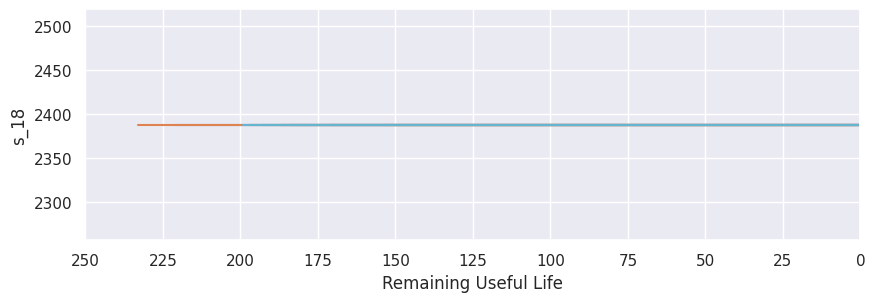




Sensor 19 - (Required fan conversion speed)


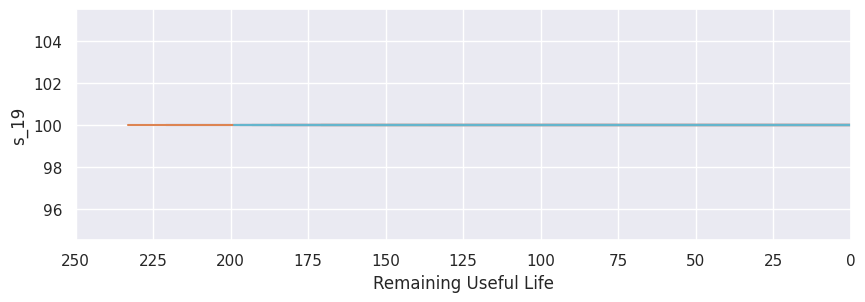




Sensor 20 - (High-pressure turbines Cool air flow)


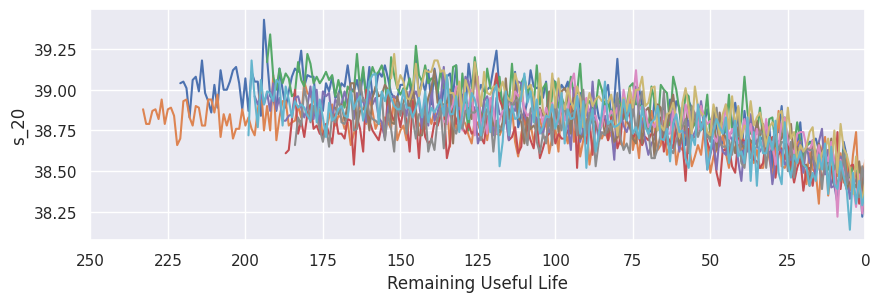




Sensor 21 - (Low-pressure turbines Cool air flow)


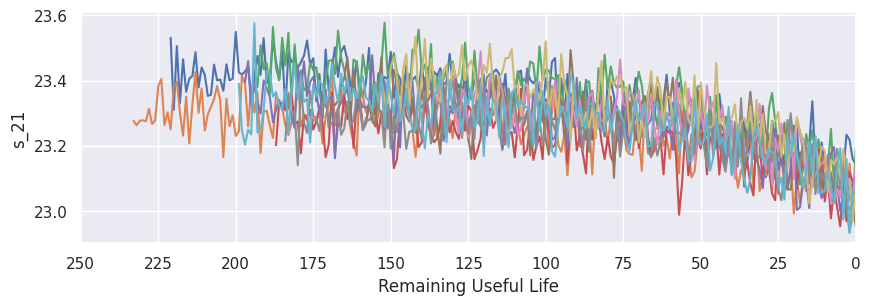

In [34]:
for s in data.drop([
           'unit_nr',
           'time_cycles',
           'setting_1',
           'setting_2',
           'setting_3',
           'RUL',
           'increasing',
           'decreasing',
          ],axis=1).columns:
    
    sname=s.split('s_')[1]
    print(f'Sensor {sname} - {Sensor_dictionary[s]}')
    plot_sensor(s,data)
    print('\n\n')

Some valuable insights from the previous plots:

- Sensors 1, 5, 16 and 19 look similar but don’t seem very useful
- Sensor 2, 3, 4, 11, and 17 show a similar upward trend and should be included for further model development.
- Sensors 6, 10 and 16 don’t reveal much trend, we’ll leave those out.
- Sensor 7, 12, 15, 20 and 21 clearly show the distinction between the two faults being developed.
- Sensor 8, 9, 13, 14 show similar patterns but with the addition of a fault condition, these signals might do more harm than good for model performance. As the signals don’t seem to distinguish between faults very well. Trying a model with and without these sensors will have to show whether these features should be included.
- Sensor 18 doesn’t seem to hold any information after condition-based standardization. Time to start preparing for our LSTM.


In [35]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
drop_sensors

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

# LSTM

Explaining how an LSTM works is a bit out of scope for this blogpost, you can find excellent resources on the internet if you wish to read-up on the technique [2]. I will focus mostly on how to apply the algorithm. I’ve mainly chosen the LSTM for its capability to work with sequences, which is a useful way of arranging your data while working with timeseries. I’ll explain how to create sequences further down below.

## Data preparation

We can re-use some of the functions from last time, like exponential smoothing and train-validation split.

In [36]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

Exponential smoothing is a simple yet powerful smoothing algorithm. See the simplified formula below [3].

```
~Xt = a*Xt + (1 - a)*~Xt-1
```

Where ~Xt is the filtered value of Xt and α the strength of the filter. Alpha can hold a value between 0–1. When alpha = 0.8, the filtered datapoint will be comprised of 80% of the value at Xt and 20% of the (already filtered) value at Xt-1. Values of alpha closer to 0 result in a more prominent smoothing effect.

In [37]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

It’s important for model validation that records of a single engine don’t get divided between train and validation sets. The LSTM may be able to predict correctly on the validation set by interpolation, which provides a false sense of the prediction error. When the model is fed truly unseen data it will perform much worse as it can no longer predict the RUL by interpolation. The train_val_group_split splits the data in such a way that all records of a single engine are assigned to either the training or validation set.

Next, we’ll discuss generating the sequences used by LSTM models.

## Sequences

Ideally, you’d use something like TimeseriesGenerator from tensorflow to create your sequences, but there’s a few reasons why I opt to use custom code.

First, we need to account for unit_nrs. Sequences should only have data of a single unit_nr to prevent mixing records where failure is imminent with records of the next engine in the train set which is still running fine.

Second, timeseries usually use X timepoints to predict Yt+1, whereas I want to predict Yt. Predicting Yt instead of Yt+1 achieves two things:

(I) First and foremost, it’s in line with all previous data framings we’ve used throughout this short series and

(II) it allows us to feed a tiny bit more data to the algorithm. Where you’d naturally use your second to last record to predict the last target, we can now use the last record to predict the last target (see figure 1 below). Although, it’s only 1 additional record per engine, it can make a difference for very small subsets. For example, some engines in the test set only consist of a couple of records.

<figure>
  <div align='center'>
    <img src='https://miro.medium.com/v2/resize:fit:640/format:webp/1*scib1bBD5vC0Cgw7C3SAkw.png' alt='Your Image Description'>
  </div>
  <div align='center'>
    <figcaption>Figure 2: On the left the traditional time series problem framing where X timepoints are used to predict Yt+1. On the right the problem framing I want to implement.
</figcaption>
  </div>
</figure>

The example dataframe from figure 2 is used to showcase the effects of the sequence generating code.

In [44]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [43]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [42]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [41]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

## Model training

In [ ]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

# Other Models

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np

## Initial setup

In [6]:
# define column names for easy indexing
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

train = pd.read_csv(('./data/CMAPSSData/train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv(('./data/CMAPSSData/test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(('./data/CMAPSSData/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

test_df= test.groupby('engine').agg({'cycle':'max'})
y_test['cycle'] = test_df['cycle']
cycle=[]
for i in range(len(y_test)):
    try:
        cycle.append(y_test['RUL'][i] + y_test['cycle'][i+1])
    except:
        cycle.append(198+20)

test_df['cycle']= cycle
train_df= train.groupby('engine').agg({'cycle':'max'})

In [7]:
def add_remaining_useful_life(df, max_df):
    # Get the total number of cycles for each unit
    max_cycle= max_df['cycle']
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train,train_df)
test=add_remaining_useful_life(test,test_df)

data=train.copy()
test_data=test.copy()

test_data['increasing']=test_data['sensor_2']+ test_data['sensor_3']+ test_data['sensor_4']+test_data['sensor_8']+test_data['sensor_13']+ test_data['sensor_15']+test_data['sensor_17']
data['increasing']=data['sensor_2']+ data['sensor_3']+ data['sensor_4']+data['sensor_8']+data['sensor_13']+ data['sensor_15']+data['sensor_17']
data['decreasing']=data['sensor_7']+data['sensor_12'] + data['sensor_20'] + data['sensor_21']
test_data['decreasing']=test_data['sensor_7']+test_data['sensor_12'] + test_data['sensor_20'] + test_data['sensor_21']

## Analysis on a Exponential Moving Averages

In [10]:
#Check correlation for the increasing trend sensors first
from scipy.signal import savgol_filter
def get_correlation_plots(component,a,train_PCA,x=250,y=25):
    plt.figure(figsize=(10,4))
    for engine in train_PCA.engine.unique():
        if engine%10==0:
            data= train_PCA[train_PCA['engine']==engine]
            y1=data[component].ewm(com=0.1).mean()
            y1= savgol_filter(y1, a, 3)
            #plt.figure(figsize=(10,4))
            plt.plot(data['RUL'],y1)
            #plt.plot(random['RUL'], random['ssensor_2'])
            plt.xlim(x, 0)  # reverse the x-axis so RUL counts down to zero
            plt.xticks(np.arange(0, x, y))
            plt.ylabel('Exponential Weighted Moving Average')
            plt.xlabel('Remaining Use fulLife')
            plt.grid(True)
    plt.show()

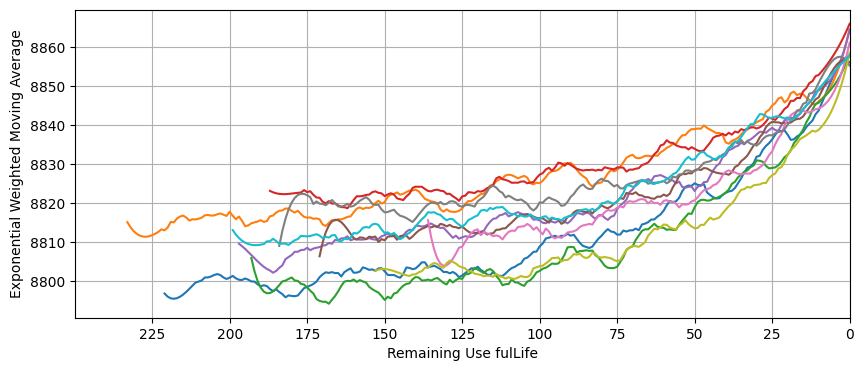

In [11]:
get_correlation_plots('increasing',21,data)

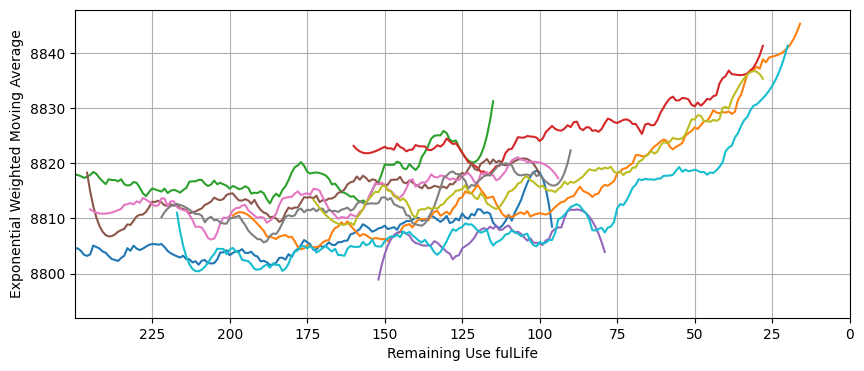

In [12]:
get_correlation_plots('increasing',21,test_data)

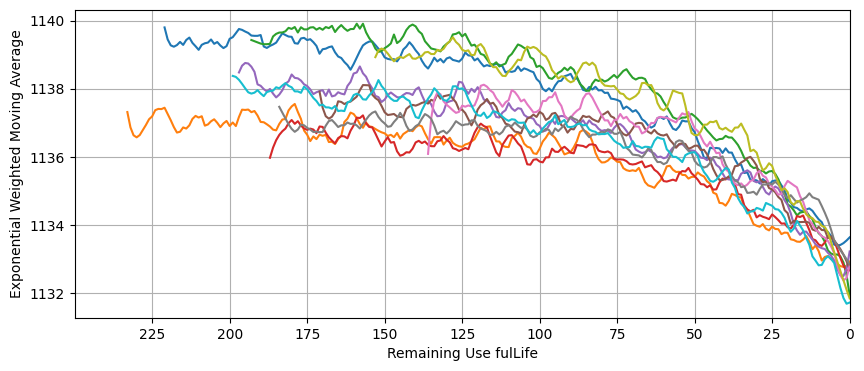

In [13]:
get_correlation_plots('decreasing',11,data)

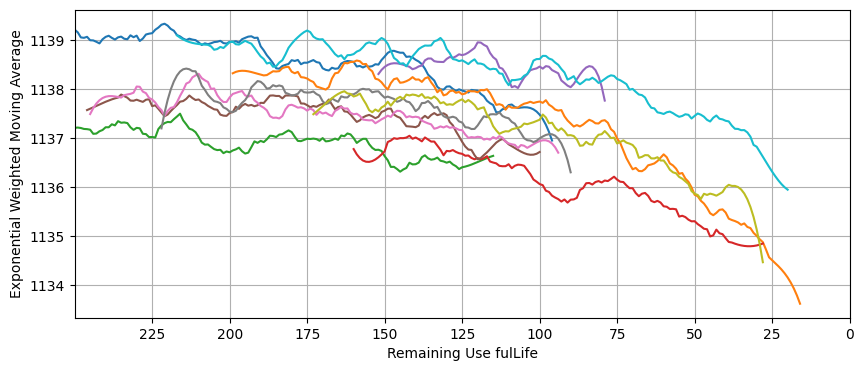

In [14]:
get_correlation_plots('decreasing',21,test_data)

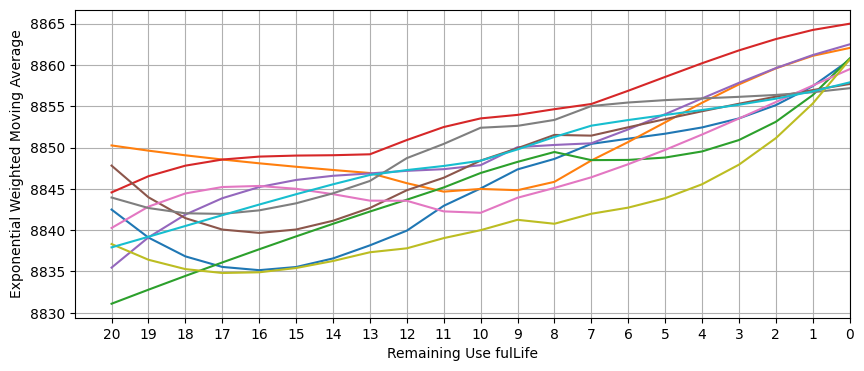

In [15]:
get_correlation_plots('increasing',15,data[data['RUL']<21],21,1)

## Health Analysis

In [16]:
corr_train=[]

for engine in data.engine.unique():
    X= data[data['engine']==engine]
    x1=X['increasing'].ewm(com=0.5).mean()
    x1= savgol_filter(x1, 27, 3)
    corr_train.append(x1)

corr_test=[]

for engine in test_data.engine.unique():
    data1= test_data[test_data['engine']==engine]
    y1=data1['increasing'].ewm(com=0.5).mean()
    y1= savgol_filter(y1, 27, 3)
    corr_test.append(y1)

def get_flat_list(comp):
    flat_list = [item for sublist in comp for item in sublist]
    return flat_list

corr_train=get_flat_list(corr_train)

corr_test=get_flat_list(corr_test)

data['EWM']= corr_train

test_data['EWM']=corr_test

data['week']= (data['RUL']/7).astype(int)

test_data['week']= (data['RUL']/7).astype(int)

data['Health']='Healthy'

test_data['Health']='Healthy'

def get_health(data):
    for i in range(len(data)):
        if data.loc[i,'RUL']<30:
            if data.loc[i,'EWM']>8830:
                data.loc[i,'Health']='Unhealthy'
            else:
                data.loc[i,'Health']= 'Health cannot be determined'
                cycle= data.loc[i,'cycle']
                engine= data.loc[i,'engine']
                print(f'Cannot determine health for engine cycle Check manually for Engine {engine}: Cycle {cycle}')
    #data.dropna(inplace= True)
    return data
    
data= get_health(data)

Cannot determine health for engine cycle Check manually for Engine 3: Cycle 150
Cannot determine health for engine cycle Check manually for Engine 3: Cycle 151
Cannot determine health for engine cycle Check manually for Engine 3: Cycle 152
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 160
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 161
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 162
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 163
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 172
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 173
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 174
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 175
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 176
Cannot determine health for engine cycle

In [17]:
test_data = get_health(test_data)

Cannot determine health for engine cycle Check manually for Engine 24: Cycle 177
Cannot determine health for engine cycle Check manually for Engine 24: Cycle 178
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 113
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 114
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 115
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 116
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 117
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 118
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 119
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 120
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 121
Cannot determine health for engine cycle Check manually for Engine 41: Cycle 112
Cannot determine health for 

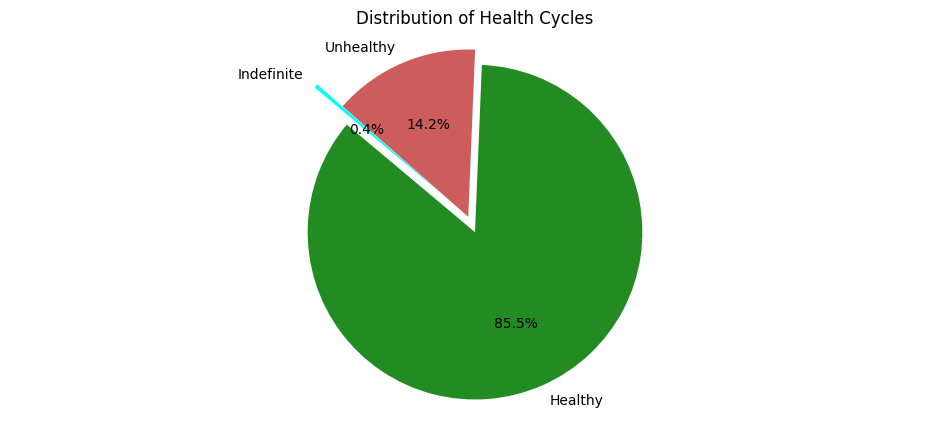

In [18]:
plt.figure(figsize=(12,5))

# Data to plot
labels= 'Healthy','Unhealthy','Indefinite'
sizes = data['Health'].value_counts()
colors = ['forestgreen','indianred','cyan']
explode = (0.1, 0,0.2)  # explode 3rd slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')

plt.title('Distribution of Health Cycles')
plt.show()

In [19]:
drop_sensor=['sensor_1',
 'sensor_5',
 'sensor_6',
 'sensor_10',
 'sensor_16',
 'sensor_18',
 'sensor_19']

test_data['Health'].value_counts()

Health
Healthy                        12789
Unhealthy                        275
Health cannot be determined       32
Name: count, dtype: int64

## f_regression

In [45]:
from sklearn.feature_selection import f_regression

In [46]:
X_train_clf= data.drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health']+drop_sensor)
X_test_clf= test_data.drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health']+drop_sensor)

X_test_clf.columns

Index(['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_17', 'sensor_20', 'sensor_21', 'RUL', 'increasing',
       'decreasing', 'EWM', 'week'],
      dtype='object')

In [47]:
y_train_clf = data['Health']
y_test_clf= test_data['Health']

In [48]:
X_train_reg= data[data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor)
X_test_reg= test_data[test_data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor)

In [49]:
y_train_reg= data[data['Health']=='Unhealthy']['RUL']
f_scores = f_regression(X_train_reg,y_train_reg)

Text(0.5, 1.0, 'F-score  for numerical features')

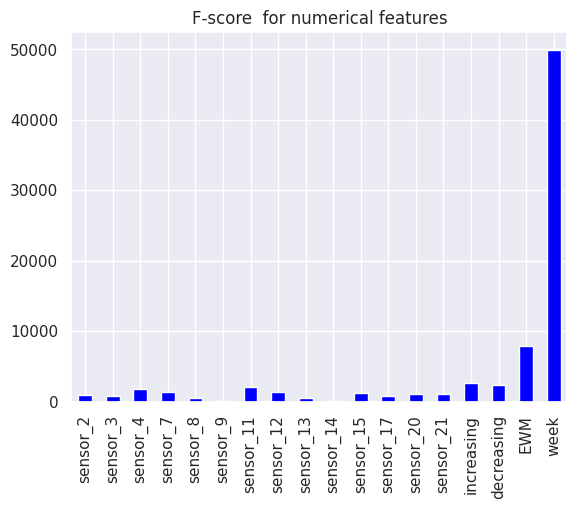

In [50]:
#The first array consists of f score-values that we need

p_series= pd.Series(f_scores[0],index= X_train_reg.columns)

p_series.plot(kind='bar',color='blue')

plt.title('F-score  for numerical features')

## Random Forest

In [51]:
least_f=['sensor_2','sensor_3','sensor_7','sensor_8','sensor_9','sensor_11']

X_train_reg= data[data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor+least_f)
X_test_reg= test_data[test_data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor+least_f)
y_train_reg= data[data['Health']=='Unhealthy']['RUL']
y_test_reg= test_data[test_data['Health']=='Unhealthy']['RUL']

In [52]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

#Random Forest Regressor param_dict
n_estimators = [30,50,80,100,120,150]
max_depth = [4,6,8,10,12]
min_samples_split = [50,80,100,150,200]
min_samples_leaf = [10,30,40,50,60,80]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor()

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train_reg,y_train_reg)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [4, 6, 8, 10, 12],
                                        'min_samples_leaf': [10, 30, 40, 50, 60,
                                                             80],
                                        'min_samples_split': [50, 80, 100, 150,
                                                              200],
                                        'n_estimators': [30, 50, 80, 100, 120,
                                                         150]})

In [53]:
#Building optimal model on the best estimators
rf_optimal_model = rf_random.best_estimator_

# make predictions for test data
y_hat = rf_optimal_model.predict(X_test_reg)

In [54]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

rms=[]

sma=[]

model=[]

variance=[]

#This function calculates R2, SMAPE and RMSE for the models that we enter for test and train sets
from sklearn.metrics import mean_squared_error,r2_score
def evaluate(m,y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    var = r2_score(y_true, y_hat)
    s= smape(y_true,y_hat)
    print('{}: {} set RMSE:{}, SMAPE: {}, R Squared : {}'.format(m,label, rmse,s,var))
    rms.append(rmse)
    sma.append(s)
    model.append(m)
    variance.append(var)

print(evaluate('Random Forest Regressor',y_train_reg,rf_optimal_model.predict(X_train_reg),'train'),'\n')
print(evaluate('Random Forest Regressor',y_test_reg,y_hat),'\n')

Random Forest Regressor: train set RMSE:1.566155619717435, SMAPE: 20.591308727418824, R Squared : 0.9662670141039723
None 

Random Forest Regressor: test set RMSE:10.029695593256767, SMAPE: 38.319511727538604, R Squared : -1.9423477393906725
None 



## Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
# create and fit model
lm = LinearRegression()
lm.fit(X_train_reg, y_train_reg)

# predict and evaluate
y_hat_train_reg = lm.predict(X_train_reg)
evaluate('Linear Regression',y_train_reg, y_hat_train_reg, 'train')

y_hat_test = lm.predict(X_test_reg)
evaluate('Linear Regression',y_test_reg, y_hat_test)

Linear Regression: train set RMSE:1.82451042882136, SMAPE: 22.84482221400016, R Squared : 0.9542198028475031
Linear Regression: test set RMSE:81.69222476170413, SMAPE: 116.030176490062, R Squared : -194.20005740844252


## XGBoost Regressor

In [56]:
from xgboost import XGBRegressor
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train_reg,y_train_reg)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:48:22] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[15:48:22] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[15:48:22] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[15:48:22] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[15:48:22] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'max_depth': [4, 6, 8],
                                        'min_samples_leaf': [40, 50],
                                        'min_samples_split': [50, 100, 150],
                                        'n_estimators': [50, 80, 100]},
                   verbose=2)

In [84]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_train_clf, y_train_clf = smote.fit_resample(X_train_clf, y_train_clf)
X_test_clf,y_test_clf=smote.fit_resample(X_test_clf,y_test_clf)

In [85]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_clf, y_train_clf)

KNeighborsClassifier()

In [87]:
print(classification_report(y_test_clf, classifier.predict(X_test_clf)))

AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [110]:
#Building optimal model on the best estimators
xgb_model = xgb_random.best_estimator_

# make predictions for test data
y_pred = xgb_model.predict(X_test_reg)

y_hat_train_reg = xgb_model.predict(X_train_reg)

# predict and evaluate
y_hat_train_reg = xgb_model.predict(X_train_reg)
evaluate('XGBoost Regressor',y_train_reg, y_hat_train_reg, 'train')
evaluate('XGBoost Regressor',y_test_reg, y_pred)

XGBoost Regressor: train set RMSE:1.4691628442336526, SMAPE: 19.267712316602587, R Squared : 0.9703158354049732
XGBoost Regressor: test set RMSE:9.597123627547061, SMAPE: 37.04368970939261, R Squared : -1.6940191129822426


## LightGBM Regressor

In [57]:
import lightgbm as lgb
reg = lgb.LGBMRegressor()
reg.fit(X_train_reg, y_train_reg)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2131
[LightGBM] [Info] Number of data points in the train set: 2923, number of used features: 12
[LightGBM] [Info] Start training from score 14.176873


LGBMRegressor()

In [58]:
# Number of trees
n_estimators = [50,80,100]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
lgb_model = lgb.LGBMRegressor(learning_rate=0.05)

#RandomSearch
lgb_random = RandomizedSearchCV(lgb_model,param_dict,verbose=2,cv=5)
# Maximum depth of trees
max_depth = [4,6,8]


lgb_random.fit(X_train_reg,y_train_reg)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=50. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=50. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 2338, number of used features: 12
[LightGBM] [Info] Start training from score 14.173225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(learning_rate=0.05),
                   param_distributions={'max_depth': [4, 6, 8],
                                        'min_samples_leaf': [40, 50],
                                        'min_samples_split': [50, 100, 150],
                                        'n_estimators': [50, 80, 100]},
                   verbose=2)

In [59]:
#Building optimal model on the best estimators
lgb_model = lgb_random.best_estimator_

# make predictions for test data
y_pred_lgb = lgb_model.predict(X_test_reg)

y_hat_train_reg =  lgb_model.predict(X_train_reg)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=40. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=40. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Unknown parameter: min_samples_split


In [60]:
# predict and evaluate
evaluate('Light GBM Regressor',y_train_reg, y_hat_train_reg, 'train')
evaluate('Light GBM Regressor',y_test_reg, y_pred_lgb)

Light GBM Regressor: train set RMSE:1.5760755418306795, SMAPE: 20.268253982977477, R Squared : 0.9658383359499375
Light GBM Regressor: test set RMSE:9.588594344921457, SMAPE: 36.88652494239801, R Squared : -1.6892327122592032


## All models condensed

In [41]:
model=['Random Forest Regressor','Linear Regression','XGBoost Regressor','Light GBM Regressor']

rmse_train= []

smape_train= []

rmse_test=[]

smape_test=[]

r_train=[]

r_test=[]

for i in range(len(rms)):
    if i%2==0:
        rmse_train.append(rms[i])
        smape_train.append(sma[i])
        r_train.append(variance[i])
    else:
        rmse_test.append(rms[i])
        smape_test.append(sma[i])
        r_test.append(variance[i])

In [ ]:
scores=pd.DataFrame()

scores['Model']=model
scores['RMSE Train']=rmse_train[0:len(model)]
scores['R_Squared Train']= r_train[0:len(model)]
scores['R_Squared Test']= r_test[0:len(model)]
scores['RMSE Test']= rmse_test[0:len(model)]
scores['SMAPE Train']= smape_train[0:len(model)]
scores['SMAPE Test']=smape_test[0:len(model)]

scores

<Figure size 2000x1000 with 0 Axes>

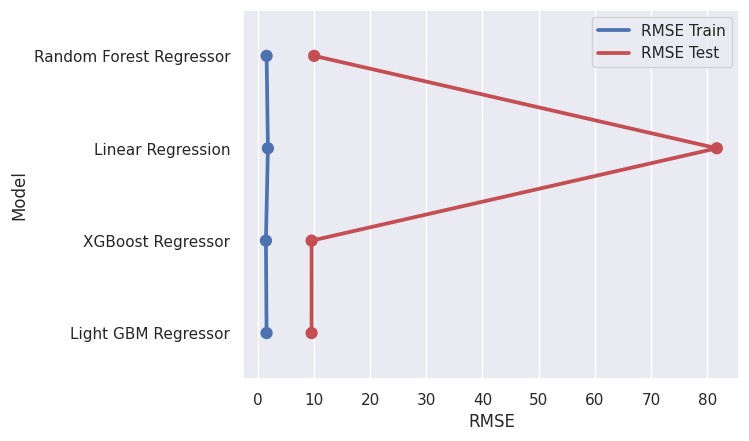

In [134]:
ax=plt.figure(figsize=(20,10))
# creating subplots
ax = plt.subplots()
# plotting columns
ax = sns.pointplot(x=scores["RMSE Train"], y=scores["Model"], color='b')
ax = sns.pointplot(x=scores["RMSE Test"], y=scores["Model"], color='r')
# renaming the axes
ax.set(xlabel="RMSE", ylabel="Model")
ax.legend(handles=ax.lines[::len(scores)+1], labels=["RMSE Train","RMSE Test"])


# visulaizing illustration
plt.show()

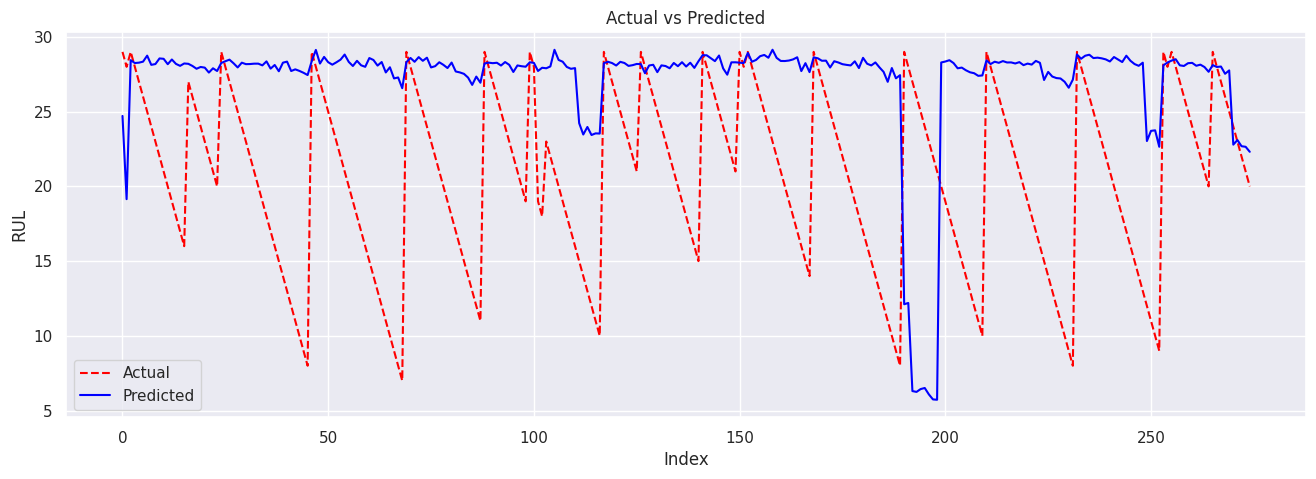

In [137]:
y_actual= y_test_reg
y_pred= y_pred

index=[]
for i in range (len(y_actual)):
    index.append(i)

plt.figure(figsize=(16,5))

plt.plot(index,y_actual,color='red',linestyle='dashed')

plt.plot(index,y_pred,color='blue')

plt.ylabel('RUL')

plt.xlabel('Index')

plt.title('Actual vs Predicted')

plt.legend(['Actual','Predicted'])

## Models explanation with SHAP

remembering our data...

In [143]:
data.head()

,engine,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_18,sensor_19,sensor_20,sensor_21,RUL,increasing,decreasing,EWM,week,Health
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388,100.0,39.06,23.4190,191,8808.6195,1138.4990,8810.380955,27,Healthy
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388,100.0,39.00,23.4236,190,8813.6518,1138.4536,8809.318319,27,Healthy
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388,100.0,38.95,23.3442,189,8809.0678,1138.9742,8808.385162,27,Healthy
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388,100.0,38.88,23.3739,188,8803.5682,1139.5639,8807.575572,26,Healthy
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388,100.0,38.90,23.4044,187,8808.9694,1138.4944,8806.883640,26,Healthy


In [140]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)
# Calculate Shap values
shap_values =shap.TreeExplainer(xgb_model).shap_values(pd.DataFrame(X_train_reg, columns=X_train_reg.columns))

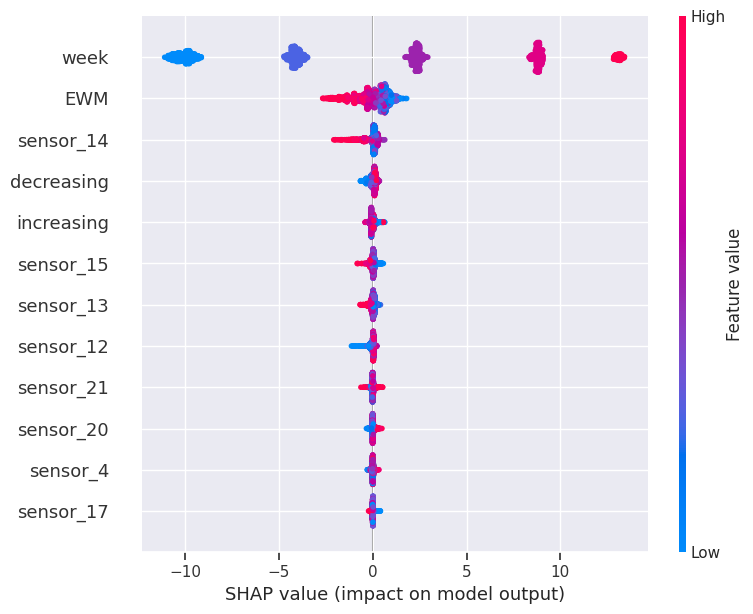

In [141]:
shap.summary_plot(shap_values, X_train_reg, feature_names=X_train_reg.columns.tolist())

# References

[1] F. O. Heimes, “Recurrent neural networks for remaining useful life estimation,” 2008 International Conference on Prognostics and Health Management, Denver, CO, 2008, pp. 1–6, doi: 10.1109/PHM.2008.4711422.

[2] http://colah.github.io/posts/2015-08-Understanding-LSTMs/

[3] Duarte Pasa, G., Paixão de Medeiros, I., & Yoneyama, T. (2019). Operating Condition-Invariant Neural Network-based Prognostics Methods applied on Turbofan Aircraft Engines. Annual Conference of the PHM Society, 11(1). https://doi.org/10.36001/phmconf.2019.v11i1.786

[4] https://github.com/Azure/lstms_for_predictive_maintenance

[5] Primer on developing reproducible Neural Networks in Jupyter Notebook

[6] Zheng, Alice. Evaluating Machine Learning Models. O’Reilly Media, Inc. 2015

[7] J. Li, X. Li and D. He, “A Directed Acyclic Graph Network Combined With CNN and LSTM for Remaining Useful Life Prediction,” in IEEE Access, vol. 7, pp. 75464–75475, 2019, doi: 10.1109/ACCESS.2019.2919566.

[8] https://www.researchgate.net/profile/Jianjun_Shi/publication/260662503_A_Data-Level_Fusion_Model_for_Developing_Composite_Health_Indices_for_Degradation_Modeling_and_Prognostic_Analysis/links/553e47d80cf20184050e16ea.pdf

[9] http://www.pubmanitoba.ca/v1/exhibits/mh_gra_2015/coalition-10-3.pdf

[10] https://www.wapa.gov/About/the-source/Documents/AMtoolkitTSSymposium0818.pdf